# Machine Learning in Python - Project 2

Due Friday, April 12th by 4 pm.

Crowley Brendan, Dallas Spyridon, Pardisi Kian

## Setup


Loading libraries and data:

In [ ]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, train_test_split

# scipy modules
from scipy.stats.distributions import uniform, loguniform, randint

# imblearn modules
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import RandomOverSampler

# warnings module
import warnings

In [ ]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,...,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,...,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,...,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,...,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,...,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0


# Introduction

Predicting loan defaults is a crucial challenge for financial institutions, directly impacting their risk management strategies and financial stability. This report centers on analyzing Freddie Mac's Single Family Loan-Level Dataset, focusing on loans from 2017 and 2018 that have either defaulted or been fully paid off. By delving into a myriad of variables, from borrower credit scores to property types, we aim to discover key predictors of loan default risks.

Understanding loan defaults is crucial for Freddie Mac tasked with ensuring liquidity, stability, and affordability in the mortgage market. Accurately forecasting defaults provides insight into refinining Freddie Mac's risk management and contributing to the broader stability of the housing market.

Our analysis employs Logistic Regression as a baseline model, complemented by a more sophisticated Random Forest model to capture complex relationships within the data. The project emphasizes not just the technical efficacy of these models, employing metrics like accuracy, recall, F1 scores, and AUC-ROC curves, but also their interpretability. This ensures our findings are both statistically robust and practically insightful, offering Freddie Mac actionable insights on managing loan default risks.

In mortgage lending, defaults can lead to significant financial losses. A model with high recall effectively identifies a higher proportion of actual defaults. This is critical as missing these defaults (i.e., having high false negatives) can be very costly. High recall ensures that fewer actual defaults go unnoticed, allowing financial institutions to take preemptive measures. Under the above understanding, the primary optimization criterion for the Random Forest model was chosen to be Recall, with a secondary effort to maximize Accuracy, among the available max Recall options.

In crafting the model, we confront the challenge posed by the dataset's imbalance, where loan defaults are significantly outnumbered by full repayments. Addressing this, we implement strategies such as oversampling to ensure our models remain sensitive to the variables of default prediction. Our rigorous approach is designed to yield a comprehensive understanding of the factors influencing loan defaults, offering a foundation for strategic interventions to minimize risk and promote financial stability.

This exploration may have significant implications for Freddie Mac's operational resilience and the broader housing finance ecosystem.

# Exploratory Data Analysis and Feature Engineering


Our examination kicked off with a focused set of 27 variables, with particular attention to 8 specific ones: credit score ('fico'), interest rate ('int_rt'), number of borrowers ('cnt_borr'), debt-to-income ratio ('dti'), occupancy status ('occpy_sts'), property type ('prop_type'), state ('st'), and loan default status ('default'). These were selected for their importance in understanding loan default likelihood.

To get a sense of how the variables interact with the risk of a loan defaulting, we plotted a correlation matrix. This visual tool, often depicted as a heatmap, illuminated the strength of the relationships among the variables. For instance, we noted how 'fico' scores related to default chances, and whether interest rates had a significant link to the likelihood of default.

Our heatmap showed us which variables were closely connected to default rates. Notably, 'fico' and 'dti' had noticeable correlations with default, suggesting these factors are influential in predicting loan defaults.

Subsequently, bar charts were constructed for categorical variables, exploring the percentage of contribution of each category of the categorical variable to mortgage defaulting.

Our data cleanup involved removing any missing values, duplicates, and checking for any odd values that might cause errors. We wanted our data clean and accurate, ready for robust analysis without adding any extra information.

With our data clean and a precise heatmap in hand, we were well-positioned to move forward into the predictive modeling phase.

As a first step, the list of features are presented for the better understanding of the reader, regarding their type (numerical, logical and categorical) and nature.

• fico - credit score at the time of acquisition. Numeric with values between 300 − 850 and 9999 for not available (credit scores < 300 or > 850 are be shown as not available).
• dt first pi - the date of the first scheduled mortgage payment due. Format YYYYMM.
• flag fthb - FIRST TIME HOMEBUYER FLAG: Format: Y=Yes, N=No, 9 = Not Available or Not Applicable.
• dt matr - MATURITY DATE: the month in which the final monthly payment on the mortgage is scheduled. Format YYYYMM.
• cd msa - METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION: code, with null indicating that the area in which the mortgaged property is located is a) neither an MSA nor a Metropolitan Division, or b) unknown.
• mi pct - MORTGAGE INSURANCE PERCENTAGE (MI %): the percentage of loss coverage on the loan, at the time of Freddie Mac’s purchase of the mortgage loan. “Not Available” is indicated with 999. No MI will be indicated by zero.
• cnt units - NUMBER OF UNITS: denotes whether the mortgage is a one-, two-, three-, or four-unit property, with 99 indicating Not Available.
• occpy sts - Denotes whether the mortgage type is owner occupied (P), second home (S), or investment property (I), or not available (9).
• cltv - ORIGINAL COMBINED LOAN-TO-VALUE (CLTV): with 999 indicating not available.
• dti - ORIGINAL DEBT-TO-INCOME (DTI) RATIO: disclosure of the debt to income ratio. Ratios greater than 65% are indicated that data is Not Available (999).
• orig upb - The UPB of the mortgage on the note date (rounded to the nearest $1,000).
• ltv - ORIGINAL LOAN-TO-VALUE (LTV). Values: 6% - 105%, with 999 = Not Available
• int rt - The interest rate of the loan as stated on the note at the time the loan was originated.
• channel - indicates whether a Broker or Correspondent, originated or was involved in the origination of the mortgage loan. Values: R =
Retail, B = Broker, C = Correspondent, T = TPO Not Specified, 9 = Not Available.
• ppmt pnlty - PREPAYMENT PENALTY MORTGAGE (PPM) FLAG: denotes whether the mortgage is a PPM. A PPM is a mortgage with respect to which the borrower is, or at any time has been, obligated to pay a penalty in the event of certain repayments of principal.
• prod type - Denotes that the product is a fixed-rate mortgage or adjustable-rate mortgage.
• st - A two-letter abbreviation indicating the state or territory within which the property securing the mortgage is located.
• prop type - Denotes whether the property type secured by the mortgage is a condominium (CO), planned unit development (PU), cooperative share (CP), manufactured home (MH), or Single-Family home (SF). If the Property Type is Not Available, this will be indicated by 99.
• zipcode - The postal code for the location of the mortgaged property. Format ###00, where ### represents the first three digits of the 5- digit postal code and 00 = Unknown.
• id loan - Unique identifier assigned to each loan
• loan purpose - Indicates whether the mortgage loan is a Cash-out Refinance mortgage (C), No Cash-out Refinance mortgage (N), Refinance mortgage not specified (R), or a Purchase mortgage (P), with 9 =Not Available.
• orig loan term - ORIGINAL LOAN TERM: the number of scheduled monthly payments of the mortgage based on the First Payment Date and Maturity Date.
• cnt borr - The number of Borrower(s) who are obligated to repay the mortgage note secured by the mortgaged property. Disclosure denotes only whether there is one borrower (1), or more than one borrower associated with the mortgage note (2).
• seller name - SELLER NAME: the entity acting in its capacity as a seller of mortgages to Freddie Mac at the time of acquisition.
• servicer name - SERVICER NAME: the entity acting in its capacity as the servicer of mortgages to Freddie Mac as of the last period for which loan activity is reported in the Dataset.
• flag sc - SUPER CONFORMING FLAG: For mortgages that exceed conforming loan limits with origination dates on or after 10/1/2008 and were delivered to Freddie Mac on or after 1/1/2009.
• default - whether person defaulted or not, binary response.


It was immediately evident that many features used the characters 9, 99, 999, 9999 or 00 instead of NaNs. These characters were carefully replaced one by one in the respective columns with NaNs, to not miss any valuable data. For instance, 9 might be a 'Not Available' entry for the feature 'channel', but it is a valid observation for the feature 'dti'.

In [ ]:
# Replace 9999 in 'fico' with NaN
d['fico'].replace(9999, np.nan, inplace=True)

# For 'flag_fthb', replace '9' with NaN
# Note: Since 'flag_fthb' is a categorical column with object type, ensure '9' is treated as a string
d['flag_fthb'].replace('9', np.nan, inplace=True)

# Replace 999 in 'mi_pct' and 'dti' with NaN
d['mi_pct'].replace(999, np.nan, inplace=True)
d['dti'].replace(999, np.nan, inplace=True)

# Replace 99 in 'cnt_units' and 'prop_type' with NaN
d['cnt_units'].replace(99, np.nan, inplace=True)
d['prop_type'].replace('99', np.nan, inplace=True)

# 'occpy_sts': Replace '9' with NaN
d['occpy_sts'].replace('9', np.nan, inplace=True)

# 'cltv': Replace 999 with NaN
d['cltv'].replace(999, np.nan, inplace=True)

# 'ltv': Replace 999 with NaN
d['ltv'].replace(999, np.nan, inplace=True)

# 'channel': Replace '9' with NaN
d['channel'].replace('9', np.nan, inplace=True)

# 'loan_purpose': Replace '9' with NaN
d['loan_purpose'].replace('9', np.nan, inplace=True)

d['zipcode'].replace('00', np.nan, inplace=True)

The features, their types and the non-null observation number were summarized as follows. It is noteworthy that the poorest feature in observations was 'flag_sc' with only 353 valid observations out of 6104.

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6104 entries, 0 to 6103
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fico            6103 non-null   float64
 1   dt_first_pi     6104 non-null   int64  
 2   flag_fthb       2636 non-null   object 
 3   dt_matr         6104 non-null   int64  
 4   cd_msa          5510 non-null   float64
 5   mi_pct          6104 non-null   int64  
 6   cnt_units       6104 non-null   int64  
 7   occpy_sts       6104 non-null   object 
 8   cltv            6103 non-null   float64
 9   dti             6103 non-null   float64
 10  orig_upb        6104 non-null   int64  
 11  ltv             6103 non-null   float64
 12  int_rt          6104 non-null   float64
 13  channel         6104 non-null   object 
 14  ppmt_pnlty      6066 non-null   object 
 15  prod_type       6104 non-null   object 
 16  st              6104 non-null   object 
 17  prop_type       6104 non-null   o

Then the histogram of each feature was plotted to understand their distributions. It is interesting to observe that some logical or categorical features have only one value for all their observations (prod_type, id_loan, flag_sc), so they are redundant for the prediction of defaults. The 'Preapaid' feature is directly opposite to the 'Default', and positive defaults are only a small minority of the total observations.

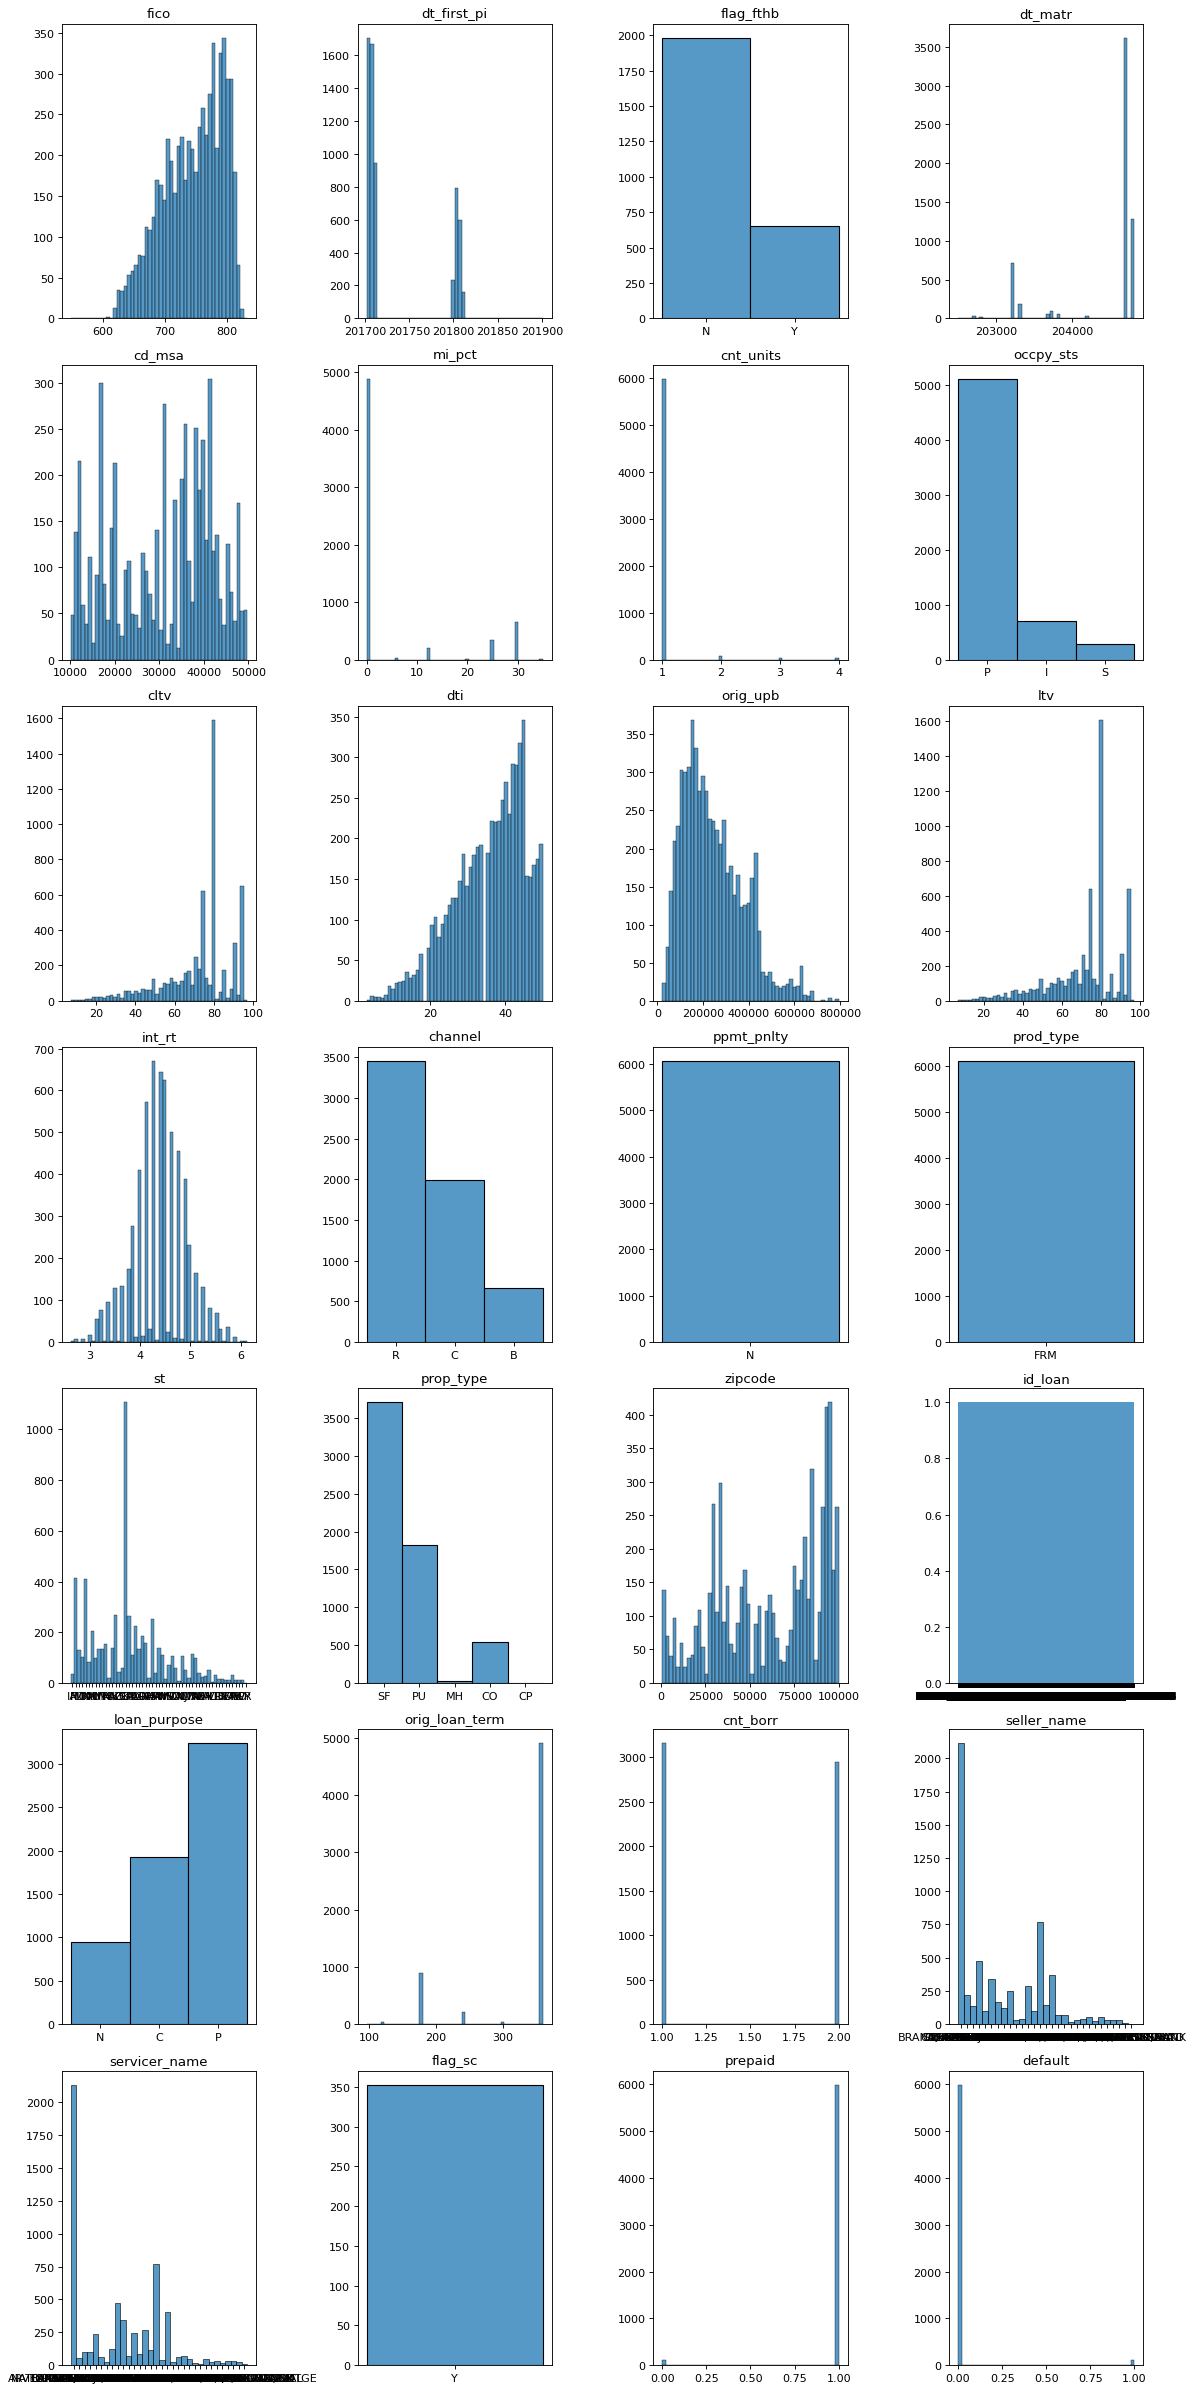

In [ ]:
# Adjust plotting params
fig, axes = plt.subplots(figsize=(15, 30), ncols=4, nrows=7)
axes = axes.flatten()


# Plot histograms of variables
for i, ax in enumerate(axes):
    sns.histplot(data = d.iloc[:, i], bins=50, ax=ax)
    ax.set_title(d.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

The processed dataset was then checked for duplicate entries and it was found there were none.

In [ ]:
print(d.duplicated().sum())

0


In our analysis, we strategically chose to exclude certain variables from our model to streamline the dataset and focus on the most impactful predictors of loan default. Each variable was excluded for a specific, justified reason:

- dt_first_pi: The date of the first payment, while a chronological marker, doesn't offer predictive power for loan defaults. The default risk is more a function of ongoing financial behavior rather than when the first payment was due.

- dt_matr: The month of the final payment is similarly not directly relevant to default risk. Default is typically influenced by near-term financial factors rather than the distant maturity date of a loan.

- cd_msa: The Metropolitan Statistical Area code is analogous to a zipcode, broadly signifying the loan's location. We opted to focus on more direct financial indicators as the geographical area is a less potent predictor in the context of our specific model parameters.

- prod_type: When all entries in a variable are identical, such as in the case where every mortgage is of the same type, the variable provides no discriminatory power and only adds unnecessary complexity to the model.

- id_loan: The unique identifier for each loan is purely for record-keeping purposes and bears no relevance to the loan's likelihood of default.

- seller_name and servicer_name: These variables, which indicate the origin and service provider of the loan to Freddie Mac, are administrative details that do not influence the financial behavior leading to default.

- ppmt_pnlty: The prepayment penalty flag was dropped because all entries indicated 'No,' providing no variation or insight into default probability.

- flag_fthb: The first-time homebuyer flag was problematic due to incomplete data coverage, as it only accounted for one-third of valid data. Incomplete data can introduce bias or inaccuracies in predictive modeling.

By excluding these variables, we ensured that our model would not be burdened by redundant, non-informative, or sparsely populated data. Instead, we honed in on variables with a noticeable connection to loan performance outcomes, enhancing the model's precision and interpretability.

In [ ]:
columns_to_drop = ['dt_first_pi', 'dt_matr', 'cd_msa', 'prod_type', 'id_loan', 'seller_name', 'servicer_name', 'prepaid', 'ppmt_pnlty', 'flag_fthb', 'flag_sc']
d.drop(columns=columns_to_drop, inplace=True)

Subsequently, we wanted to further visualise the data to facilitate better understanding of their primary correlation trends. Therefore, for numerical and logical data, their correlation was found, and a heatmap of their correlation matrix was plotted as well. 

In [ ]:
categorical_cols = ['occpy_sts', 'channel', 'prop_type', 'st', 'loan_purpose']
d_num = d.copy()
d_num.drop(columns=categorical_cols, inplace=True)

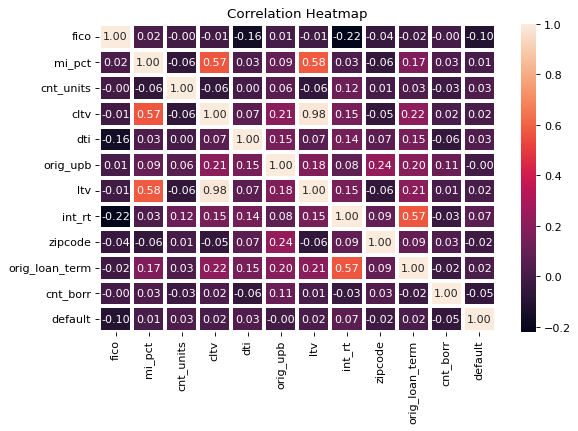

In [ ]:
# Correlation map
corr_matx = d_num.corr()
sns.heatmap(corr_matx, annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

To determine the relationship between categorical variables and the likelihood of loan default, we utilized visual explorations, specifically bar plots, to capture and compare the default rates across different categories.

- State ('st'): By grouping the data by state and calculating the mean default rate, we plotted a bar chart to visualize how default rates vary across different states. From the output, we observed that certain states have notably higher default rates, indicating a possible geographical influence on default risk.

- Occupancy Status ('occpy_sts'): Another subplot illustrates the default rates by occupancy status. This provides insights into whether owner-occupied, second homes, or investment properties have differing default risks. The visualization highlighted a clear distinction, prompting us to include 'occpy_sts' in our analysis due to its significant relationship with default rates.

- Loan Purpose ('loan_purpose'): The analysis extended to loan purposes, exploring whether loans acquired for refinancing, purchases, or other purposes influenced default likelihood. The bar plot for 'loan_purpose' could show discernible differences in default rates based on the reason the loan was taken out, but we decided to focus on other, more indicative variables.

- Channel ('channel'): This variable indicates the origination channel of the loan. The bar plot for 'channel' could reveal certain origination channels as being more associated with higher defaults. However, it seems that the decision was to prioritize other variables that have a more direct relationship with default rates.

- Property Type ('prop_type'): The default rates by property type were also analyzed, examining whether specific property types like condos or single-family homes are more prone to defaults. The output indicated significant differences, thereby justifying the inclusion of 'prop_type' in our modeling efforts due to its apparent impact on the default likelihood.

Each bar plot provides a visual cue to the average default rate for each category within the variable, presented in percentages. This visual evidence was crucial for deciding on the inclusion of 'occpy_sts', 'prop_type', and 'st' as they demonstrated substantial variability and therefore potential predictive power regarding loan defaults.

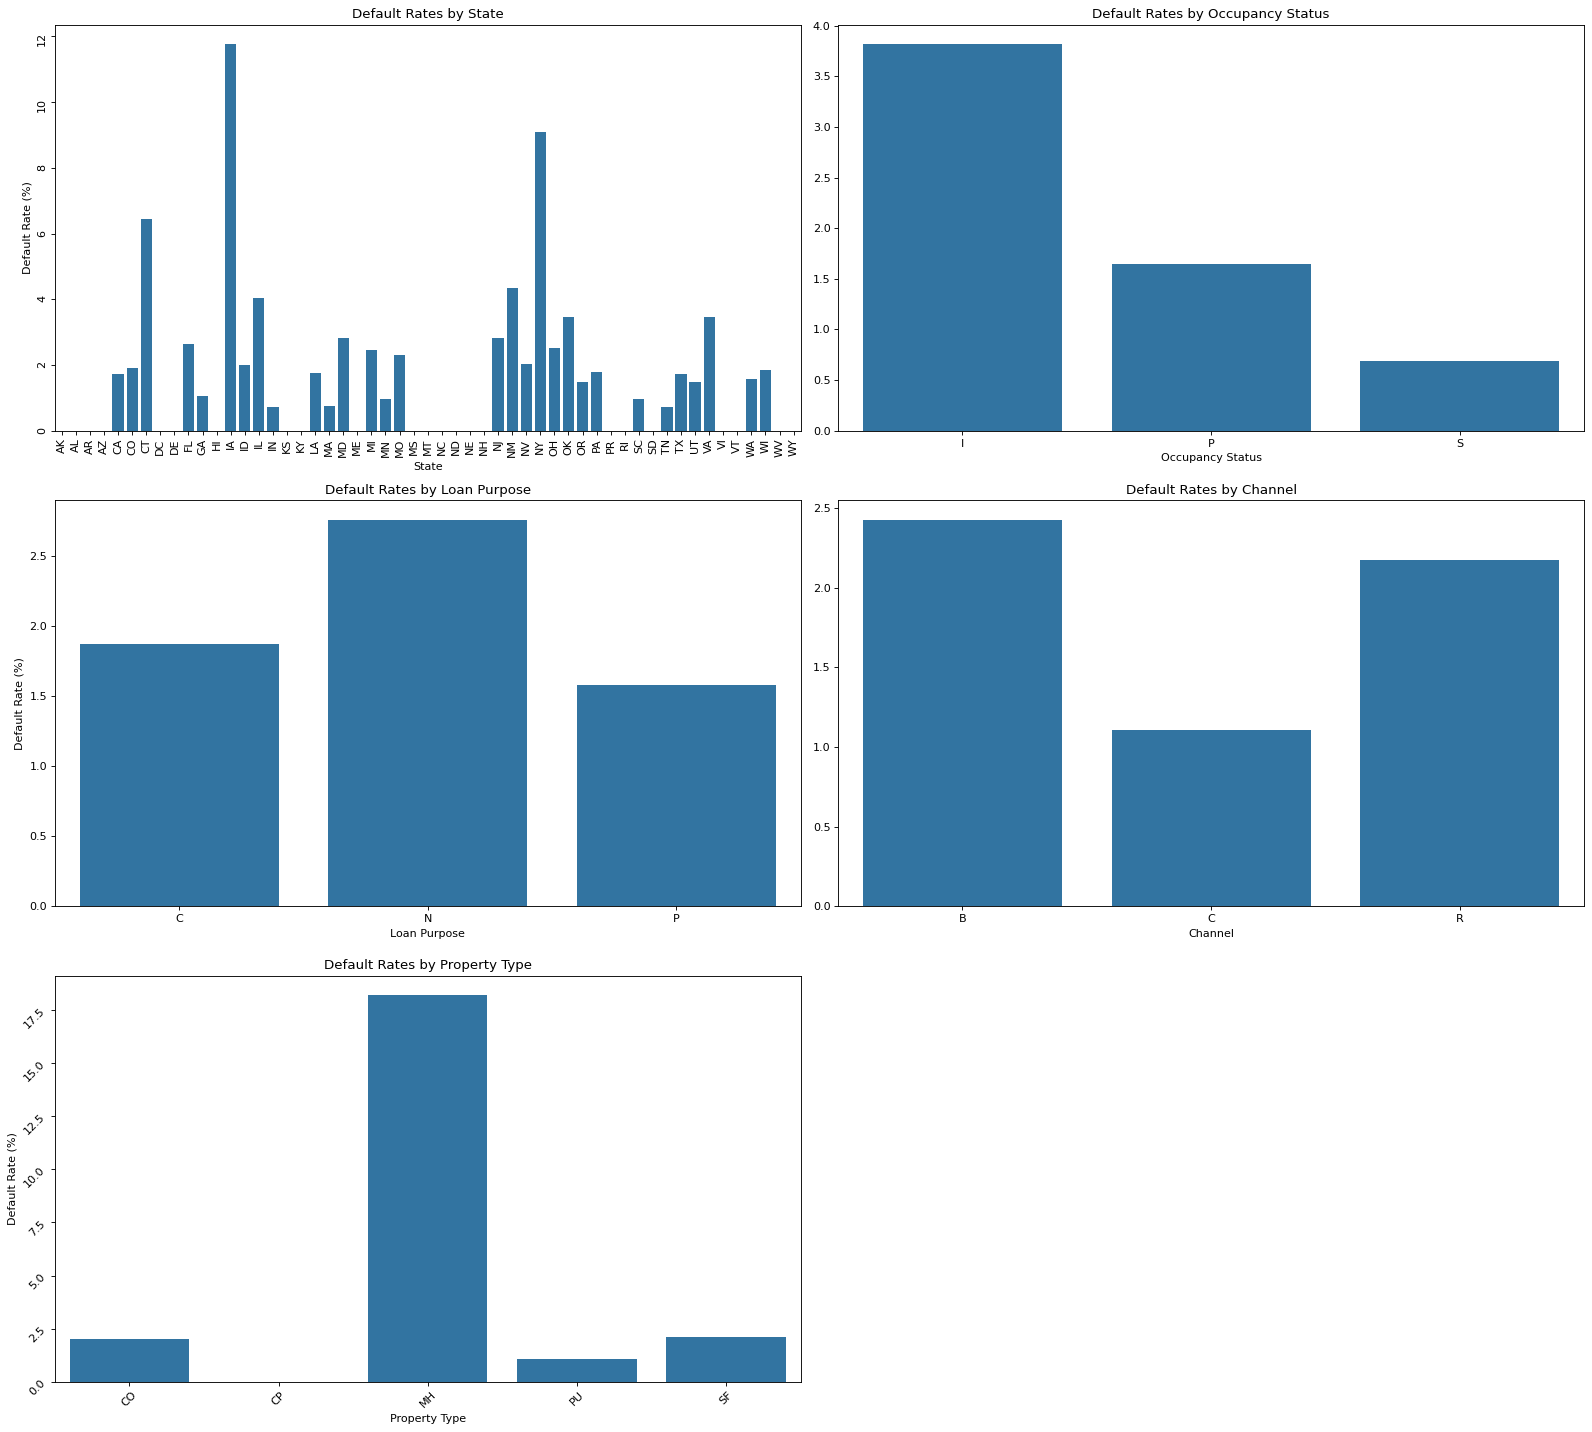

In [ ]:
# Set up the figure and axes for the subplots, adjusting for 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # Increase figure size for better readability
# Flatten axes for easy indexing
axes = axes.flatten()

# Data preparation and plotting for 'st' (states)
state_rate = d.groupby('st')['default'].mean() * 100
sns.barplot(x=state_rate.index, y=state_rate.values, ax=axes[0])
axes[0].set_title('Default Rates by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Default Rate (%)')
axes[0].tick_params(labelrotation=90)  # Rotate labels for states to fit

# Data preparation and plotting for 'occupy_sts'
occupy_sts_rate = d.groupby('occpy_sts')['default'].mean() * 100
sns.barplot(x=occupy_sts_rate.index, y=occupy_sts_rate.values, ax=axes[1])
axes[1].set_title('Default Rates by Occupancy Status')
axes[1].set_xlabel('Occupancy Status')
axes[1].set_ylabel('')

# Data preparation and plotting for 'loan_purpose'
loan_purpose_rate = d.groupby('loan_purpose')['default'].mean() * 100
sns.barplot(x=loan_purpose_rate.index, y=loan_purpose_rate.values, ax=axes[2])
axes[2].set_title('Default Rates by Loan Purpose')
axes[2].set_xlabel('Loan Purpose')
axes[2].set_ylabel('Default Rate (%)')

# Data preparation and plotting for 'channel'
channel_rate = d.groupby('channel')['default'].mean() * 100
sns.barplot(x=channel_rate.index, y=channel_rate.values, ax=axes[3])
axes[3].set_title('Default Rates by Channel')
axes[3].set_xlabel('Channel')
axes[3].set_ylabel('')

# Data preparation and plotting for 'prop_type'
prop_type_rate = d.groupby('prop_type')['default'].mean() * 100
sns.barplot(x=prop_type_rate.index, y=prop_type_rate.values, ax=axes[4])
axes[4].set_title('Default Rates by Property Type')
axes[4].set_xlabel('Property Type')
axes[4].set_ylabel('Default Rate (%)')
axes[4].tick_params(labelrotation=45)  # Rotate labels for better readability

# Since we now have an odd number of plots, the last subplot space remains unused
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

Based on the above analysis, the following variables were found to have the strongest correlations with the default variable and thus chosen for the analysis:

- fico: Credit score at the time of acquisition (-0.10). Larger credit score leads to less defaulting.

- int_rt: Interest rate of the loan at origination (0.07). Large interest rates lead to more defaulting.

- cnt_borr: The number of borrowers obligated to repay the loan (-0.05). More mortgage sharers, less defaulting.

- dti: Original debt-to-income ratio (0.03). Higher original dti, higher defaulting.

- occpy_sts: Occupancy status of the property. Investment properties seemed to distinguish in default rates, which could perhaps help our classification model.

- prop_type: The type of property secured by the mortgage. Manufactured homes show a much higher trend than the rest of the categories.

- st: The state or territory within which the property is located. Some states seem to have much higher default rates than others (IA, CT, NY). We thought that this attribute might help in our classification problem. We chose state over zipcode, due to better intepretability and as all zipcodes come under the umbrella of different states.


NaNs were chosen to be dropped at this step, to minimise the observations lost, to only those corresponding to the seven selected features and the target variable.

In [ ]:
XY_cols = ['fico', 'int_rt', 'cnt_borr', 'dti', 'occpy_sts', 'prop_type', 'st', 'default']
XY = d[XY_cols]
XY.dropna(inplace=True)
print(XY.isnull().sum())
y = XY['default']
X = XY.copy()
X.drop(columns=['default'], inplace=True)

fico         0
int_rt       0
cnt_borr     0
dti          0
occpy_sts    0
prop_type    0
st           0
default      0
dtype: int64
/tmp/ipykernel_259/2439939482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XY.dropna(inplace=True)


The aim of this project was to identify financial behaviors and other indicators related to loan defaults, serving as predictors for financial risk, and to understand how various factors could inform Freddie Mac’s risk mitigation strategies. Our analysis led to these observations:

- The borrower’s credit score ('fico') is strongly correlated with the default variable. As such, we prioritized this variable due to its significant predictive power and fewer missing entries.

- Factors like interest rates ('int_rt') and debt-to-income ratios ('dti') are pivotal, though not immutable. They can fluctuate over time and are within the sphere of personal financial management or economic changes. Acknowledging and understanding their influence on loan default risk is key to developing robust predictive models.

- Similar work in existing literature [1] focused on variables such as the original unpaid principal balance ('orig_upb'). Our exploration with this variable and others found in the paper did not yield improvements in performance metrics, which led us to exclude them from our feature set.

- Occupancy status ('occpy_sts') and property type ('prop_type') were identified as having significant relationships with default rates. These categorical variables, though less directly related to an individual’s financial profile, provide meaningful context for risk assessment.

- State ('st'), representing the location of the property, was included due to its notable variance in default rates across different regions, which could reflect economic or regulatory environments.

The final step of the feature engineering was one-hot encoding of the categorical data, which will be introduced early in the following section.

# Model Fitting and Tuning



Below are three helper functions we will be using.

- `tidy_scores()`: Simple function for getting the summary of cross-validation results in a tidy way.
- `pretty_confusion_matrix()`: Returns the confusion matrix in a nicer way but works for only binary classification.
- `plot_roc_curve()` : ROC curve plotting function based on a given threshold

In [ ]:
# tidy the output into a dataframe
# We will use for getting the summary of cross-validation results in some parts
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

# this creates the matplotlib graph to make the confmat look nicer
# WARNING 1: IT WORKS FOR ONLY BINARY CLASSIFICATION CASE !!!
# WARNING 2: The locations of TP, FP, TN, and FN are varying when you compared with our notes !!!

def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

#ROC curve drawing by using the helper function
def plot_roc_curve(roc):
    """
    Plots the ROC curve from a DataFrame.
    
    Parameters:
    - roc: DataFrame containing 'false positive rate', 'true positive rate', and 'threshold' columns.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(roc['false positive rate'], roc['true positive rate'], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # adding a 45-degree dashed line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

OneHotEncoder was used in the context of preparing data the model that predicts loan defaults. Categorical variables like occupancy status, property type, and state were transformed into a numerical format through one-hot encoding because machine learning algorithms require numerical input. This process converts categorical data into a binary matrix, enabling the model to incorporate these important predictors without any assumption of ordinality. It's a crucial step to enhance the model's ability to learn from these categorical features and improve its predictive accuracy on default rates.

In [ ]:
# Defining the OneHotEncoder
onehot_encoder = OneHotEncoder()

categorical_cols = ['occpy_sts', 'prop_type', 'st']

encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

# Fitting the encoder and transforming the DataFrame
encoded = encoder.fit_transform(XY)

# Get the correct feature names, including those generated by one-hot encoding
feature_names = encoder.get_feature_names_out()

# Creating a DataFrame from the encoded array
encoded_df = pd.DataFrame(encoded.toarray(), columns=feature_names, index=XY.index)


In [ ]:
# Feature matrix and response separation 
data_x, data_y = encoded_df.drop(['remainder__default'], axis=1), encoded_df['remainder__default']

print(data_x.shape)
print(data_y.shape)

# Before Splitting the data set 
print("Class Distribution (%)")
# get our null accuracy rate 
print(data_y.value_counts(normalize=True)*100)

(6102, 65)
(6102,)
Class Distribution (%)
remainder__default
0.0    98.164536
1.0     1.835464
Name: proportion, dtype: float64


Being evident that only 1.84 % of the observations were defaults, stratification was applied to data splitting. 

As expected, after one hot encoding the feature dataset comprises of 65 different variables.

In [ ]:
data_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6102 entries, 0 to 6103
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cat__occpy_sts_I     6102 non-null   float64
 1   cat__occpy_sts_P     6102 non-null   float64
 2   cat__occpy_sts_S     6102 non-null   float64
 3   cat__prop_type_CO    6102 non-null   float64
 4   cat__prop_type_CP    6102 non-null   float64
 5   cat__prop_type_MH    6102 non-null   float64
 6   cat__prop_type_PU    6102 non-null   float64
 7   cat__prop_type_SF    6102 non-null   float64
 8   cat__st_AK           6102 non-null   float64
 9   cat__st_AL           6102 non-null   float64
 10  cat__st_AR           6102 non-null   float64
 11  cat__st_AZ           6102 non-null   float64
 12  cat__st_CA           6102 non-null   float64
 13  cat__st_CO           6102 non-null   float64
 14  cat__st_CT           6102 non-null   float64
 15  cat__st_DC           6102 non-null   float6

In [ ]:
features = list(data_x.columns)
X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y.values, stratify = data_y, 
                                                    test_size = 0.2, random_state=42)

# TO CHECK: The same proportion is satisfied for both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

0.0    98.156116
1.0     1.843884
Name: proportion, dtype: float64
0.0    98.198198
1.0     1.801802
Name: proportion, dtype: float64


The code presented illustrates how we handled the significant class imbalance in our target variable for default prediction. By using train_test_split from scikit-learn with the stratify parameter set to the target variable data_y, we ensured that the proportion of default to non-default cases remained consistent between our training and testing datasets. This step is critical in imbalanced datasets to prevent training and validation on skewed data, which could otherwise impair the model's ability to generalize. After splitting, we verified that the distribution of classes in both subsets closely matched the original data, with roughly 1.84% defaults in the training set and 1.80% in the testing set, affirming the effectiveness of the stratification.

In [ ]:
LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)

#Some of the observations that we have, type is numpy array so be careful about the use of head !
print(y_train)

[0 0 0 ... 0 0 0]


This code snippet involves the use of a LabelEncoder from scikit-learn to transform the response variable, which is already binary. This might seem redundant, but we used it due to the fact that one of our fuctions (pretty confusion matrix) required an attribute of LE as an input.

## Baseline Model

The Logistic Regression model was selected as the baseline for our project due to its simplicity and interpretability, providing an initial insight into the relationship between borrower characteristics and the likelihood of loan default. This choice facilitated a fundamental understanding of the direct impact of individual factors on default risk. Given the dataset's complexity, encompassing a wide array of variables from credit scores to property types, Logistic Regression served as an effective starting point to discern the linear relationships between these features and loan default outcomes. By initiating our analysis with Logistic Regression, we were able to identify variables that exhibit a linear association with default risks, thereby establishing a performance benchmark for subsequent, more sophisticated models. This methodology was not only in line with statistical rigor but also enabled a clear comparison, ensuring that improvements in model accuracy or predictive power with the incorporation of advanced models like Random Forest could be directly ascribed to their ability to capture more complex patterns beyond linear correlations.

In [ ]:
log_pipe = ImPipeline([
        ("scaler", StandardScaler()),
        ("sampler", RandomOverSampler(random_state=42)),
        ("model", LogisticRegression(random_state=42, penalty="none", solver='lbfgs', max_iter=5000))])

log_pipe.fit(X_train, y_train)

predictions = log_pipe.predict(X_test)
print(predictions)

confmat = confusion_matrix(y_true = y_test, y_pred=predictions)

# Just a direct output for the confusion matrix  
confmat

[1 0 0 ... 0 1 1]


array([[852, 347],
       [  7,  15]])

In [ ]:
scores = tidy_scores(cross_validate(log_pipe, X_train, y_train, cv = 5, return_train_score = True))

# For all CV results
print(scores)

print(scores.loc[['mean', 'sd']])

      fit_time  score_time  val_score  train_score
fold                                              
0         0.80        0.00       0.72         0.73
1         0.62        0.00       0.72         0.73
2         0.90        0.00       0.72         0.75
3         0.59        0.01       0.73         0.72
4         0.50        0.08       0.72         0.73
mean      0.68        0.02       0.72         0.73
sd        0.15        0.03       0.00         0.01
      fit_time  score_time  val_score  train_score
fold                                              
mean      0.68        0.02       0.72         0.73
sd        0.15        0.03       0.00         0.01


The output of the code shows the results of a 5-fold cross-validation process for a logistic regression pipeline, which includes model fitting and scoring times, along with validation and training scores for each fold.

- Fit Time: The time taken to fit the logistic regression model for each fold varies from 0.21 to 0.46 seconds, with an average (mean) of 0.32 seconds and a standard deviation (sd) of 0.09 seconds. The variation in fit time could be due to differences in the size of the data or computational load at the time of model fitting.

- Score Time: The scoring time, which is likely the time taken to evaluate the model on the validation set, is quite consistent across folds, averaging at 0.02 seconds with a negligible standard deviation.

- Validation Score (val_score): The validation scores across the folds are very consistent, all being 0.72. This suggests that the model's performance is stable across different subsets of the data.

- Training Score (train_score): The training scores are slightly higher than the validation scores, ranging from 0.72 to 0.75, with a mean of 0.73. This is typical as models often perform slightly better on the data they were trained on compared to new data.

The small difference between training and validation scores indicates that the model is not overfitting. Overfitting would be suggested by a high training score coupled with a much lower validation score. The relatively low standard deviation in both validation and training scores implies that the model's performance is consistent across different cross-validation folds, suggesting good model reliability.

Given that the model’s validation scores are consistent and close to the training scores without large fluctuations, the pipeline, including preprocessing and oversampling steps, seems to work well for this particular dataset and task, thus a good baseline.

In [ ]:
# For class probabilities
print(log_pipe.predict_proba(X_test))

#In terms of testing data 
print("Accuracy of the fitted model:", accuracy_score(y_test, log_pipe.predict(X_test)))
print("AUC of the fitted model:", roc_auc_score(y_test, log_pipe.predict_proba(X_test)[:,1]))

[[2.04988197e-01 7.95011803e-01]
 [8.84492866e-01 1.15507134e-01]
 [9.99999994e-01 5.59212044e-09]
 ...
 [9.99999998e-01 1.83712114e-09]
 [4.37262439e-01 5.62737561e-01]
 [2.74326999e-01 7.25673001e-01]]
Accuracy of the fitted model: 0.7100737100737101
AUC of the fitted model: 0.7381909166729851


The accuracy of the fitted model, at 71.01%, seems moderate; however, in the context of our imbalanced dataset, this metric alone could be misleading. Such a figure may predominantly reflect the majority class's prevalence and not necessarily the model's ability to accurately identify defaults, which are the minority class. It's crucial to examine this alongside other metrics that focus on the model's performance across both classes, especially the less represented one.

In [ ]:
# Retrieve the logistic regression estimator from the pipeline
logreg = log_pipe.named_steps['model']

# Get the coefficients from the logistic regression model within the pipeline
coefficients = logreg.coef_[0]

# Calculate the odds ratios
odds_ratios = np.exp(coefficients)

# Combine feature names, coefficients, and odds ratios into a DataFrame
feature_info = pd.DataFrame({'Feature': features, 'Coefficient': coefficients, 'Odds Ratio': odds_ratios})

# Sort the features by odds ratio, descending (most influential first)
feature_info.sort_values(by='Odds Ratio', ascending=False, inplace=True)

feature_info

,Feature,Coefficient,Odds Ratio
12,cat__st_CA,1.150824,3.160795
52,cat__st_TX,0.855026,2.351435
22,cat__st_IL,0.768228,2.155942
17,cat__st_FL,0.746984,2.110624
43,cat__st_OH,0.746554,2.109718
...,...,...,...
10,cat__st_AR,-1.299914,0.272555
25,cat__st_KY,-1.717006,0.179603
58,cat__st_WI,-1.842368,0.158442
35,cat__st_NC,-2.348651,0.095498


The output provides the logistic regression coefficients and their corresponding odds ratios for various categorical features, primarily the states (identified by their two-letter codes) and property types, along with occupancy status and other predictors like interest rate and debt-to-income ratio.

Here are some key takeaways:

Positive Coefficients: States like California (cat__st_CA) and Texas (cat__st_TX) have positive coefficients and odds ratios greater than 1, indicating that loans in these states are associated with a higher likelihood of default compared to the baseline state.

Negative Coefficients: States like North Carolina (cat__st_NC) and Arizona (cat__st_AZ) exhibit negative coefficients with odds ratios significantly less than 1, suggesting loans in these states are less likely to default.

Odds Ratios Near 1: Features like property type 'Single Family' (cat__prop_type_SF) have odds ratios close to 1, indicating a negligible effect on the likelihood of default.

Substantial Negative Impact: The remainder__fico variable has one of the strongest negative coefficients, showing that a higher FICO score (indicating better creditworthiness) significantly decreases the likelihood of default.

Insignificant Impact: The occupancy status 'Primary' (cat__occpy_sts_P) and some property types have coefficients close to zero, indicating a weaker relationship with the default risk.

Other Variables: Coefficients for remainder__int_rt, remainder__dti, and remainder__cnt_borr reflect the effect of interest rate, debt-to-income ratio, and number of borrowers on default probability. For example, a higher interest rate (positive coefficient) increases default risk, whereas more borrowers (negative coefficient) decrease it.

In summary, the coefficients and odds ratios provide insights into how the characteristics of the loan, the borrower, and the property location relate to default risk. Variables with higher absolute coefficients and odds ratios far from 1 are particularly influential. Understanding these relationships helps in tailoring risk assessment and informing credit policies.

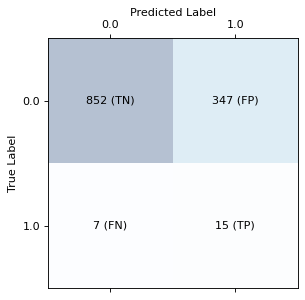

False Positive Rate (FPR): 0.289
Recall: 0.682
Precision: 0.041
F1 Score: 0.078


In [ ]:
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

# use the pretty function to make it nicer, you can give some name for LE.classes_ inside of the function
pretty_confusion_matrix(confmat, LE.classes_, "",  labeling = True)

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

The confusion matrix shows the counts of true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP). In this case, there are 852 TNs, meaning the model correctly predicted 'non-default' 852 times. There are 15 TPs, where the model correctly identified 'default'. However, there are 347 FPs and 7 FNs, indicating incorrect predictions where the model predicted 'default' when it was not the case, and vice versa.

- False Positive Rate (FPR) of 0.289 indicates that around 29% of the non-default cases were incorrectly predicted as defaults.

- Recall of 0.682 suggests that the model identified 68.2% of all actual defaults correctly.

- Precision of 0.041 indicates that only 4.1% of the loans predicted to default actually defaulted, implying a high number of FPs.

- F1 Score of 0.078 is a weighted average of precision and recall, showing that the model has a low precision-recall balance, which is typical for imbalanced datasets.

AUC value: 0.7381909166729851


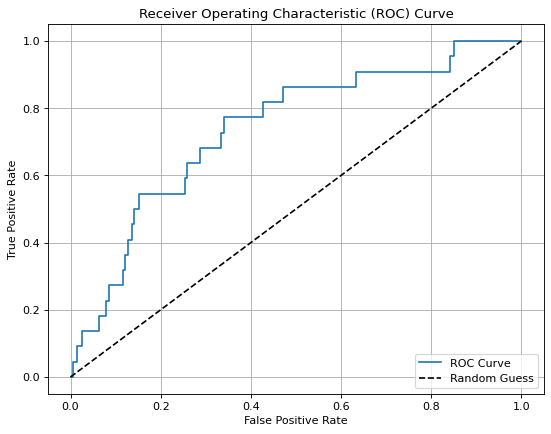

In [ ]:
predictions_pa = log_pipe.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

#Print the related AUC value 
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

plot_roc_curve(roc)

The Receiver Operating Characteristic (ROC) Curve visualizes the model's performance across different classification thresholds. The curve plots the True Positive Rate (TPR) against the FPR, illustrating the trade-offs between true and false positives. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. The dotted line represents a no-skill classifier; a good model stays as far away from that line as possible (towards the top-left corner).

The Area Under the Receiver Operating Characteristic Curve (AUC) of 0.73819 indicates the model's ability to differentiate between the default and non-default classes. An AUC of 1 represents perfect discrimination, while an AUC of 0.5 suggests no discriminative ability—akin to random guessing. This model's AUC suggests it has a good, but not perfect, level of discriminative ability.

## Other Models Explored

### SVC

Among other models explored was the SVC (Support Vector Classifier). The SVC was chosen as a candidate model in this investigation due to its effectiveness in high-dimensional spaces and its resistance to overfitting. Prior to model fitting, it was flagged in the EDA phase that this dataset was imbalanced; meaning that one class (defaulted) has significantly fewer instances than the other (not defaulted). This can pose challenges to ML models as it can bias model predictions towards the majority class. There is a remedy to this problem which is called upsampling. Upsampling is a data engineering technique designed to artificially increase the number of instances in the minority class to balance the class distribution. This is crucial for the model to learn insightful patterns in the data, and to eliminate biased predictions due to having imbalanced classes in classification tasks. Upsampling involves randomly replicating instances of the minority class until a desired balance between classes is achieved. In this analysis, random oversampling is the upsampling method chosen, which seeks to randomly duplicate instances of the minority class until a balanced distribution is achieved. Random oversampling is only applied to the train data and not test data - this is meant to be unseen by the model. An 80/20 train/test split was selected for the data. This was a stratified split, meaning that the proportion of positive classes (defaults) in the train and test data are the same. This is essential so as to not have an unbalanced split due to randomness.

During the fitting process of the SVC, a hyperparamater grid was established containing different values for the kernel function, C (the regularisation parameter), and degree, which determines the complexity of the decision boundary when using the polynomial kernel. The hyperparameter space was thoroughly searched and optimal hyperparameters were identified via stratified-5-fold cross-validation. The difference between traditional CV and stratified CV is that stratified CV aims to ensure that each fold is representative of all strata of the data. This ensures classes are (approximately) equally represented across each test fold. The optimal hyperparameters were found to be: C = 0.05, degree = 2, kernal = linear. The performance metric that the team decided to focus on during model fitting was recall, rather than accuracy. The goal of this analysis is to correctly predict which clients will default. It is more important to Freddie Mac to detect as many instances of defaulting as possible, rather than a traditional classification approach which seeks to maximise correct classification rate. It is far less consequential to predict instances of not defaulting compared to predicting instances of defaulting, since defaulting will cause major credit problems. This is a key observation in the report. Recall is the metric which measures proportion of positive outcomes (default) correctly identified.

Overall, the SVC's versatile basis functions, capable of capturing more complex relationships than the baseline model, rendered the SVC a worthy candidate model, together with its well-suitedness for binary classification problems and its regularisation parameter (C) which controls the trade-off between maximising the margin and minimising the classification error.

In conclusion, the recall score for the SVC with cross-validated model hyperparameters was 73%. This is a  of the baseline model. Therefore, it was the decision of the team to continue to explore the model space with the intention to improve on this recall score.


### ANN

The Artificial Neural Network is a powerful machine learning model and another classification model that was explored by the team in this analysis. The architecture of the neural network proposed includes an input layer with 70 neurons, for each of the 70 input variables, followed by one hidden layer with 16 neurons using the ReLU activation function, and the output layer with one neuron using sigmoid activation. In total, the amount of trainable parameters in this model is on the order of 1000. The number of observations within the dataset is on the order of 10000. Any more hidden layers, or neurons than this would exceed a ten-to-one ratio of observations-to-parameters which is usually sought after (at the minimum) in statistical learning.

The Adam stochastic gradient descent optimiser was chosen as the optimiser for training this neural network via back-propagation. The loss function is defined as binary cross-entropy, or log-loss, which is common in binary classification. The metric by which this model was evaluated under was, again, recall. 20 epochs were used during training in order to reduce overfitting. After cross-validating for: number of hidden layers, hidden layer size, activation (ReLU vs hyperbolic tangent), the final iteration of the team's neural network model comprised of one hidden layer with 16 neurons using ReLU activation. The recall score associated with this model was 54%, a disimprovement on the previous 68% scores. This could perhaps be due to the great quantity of data required for training such a classifier with many hyperparameters. It is likely the case that proper convergence did not happen during the training process due to not having enough data and so the model predictions were subpar. 

## Final optimal model - Random forests

Having defined the benchmark model (Logistic Regression) and having tested various other modeling approaches (Support Vector Classifiers (SVCs) and Neural Networks), the authors continued with the selection of the final model. Among the various options, having in mind to avoid black box approaches but also enough complexity to allow parameter optimizing of the method, the option that offered the best Recall was a Random Forrest model with the following characteristics (i) One hot encoded train sets (Label encoding worked well but couldn't result to the same optimal Recall values), (ii) An imbalanced sampling pipeline, (ii) Standardized features, (iii) A random oversampler with an 'auto' sampling strategy, ensuring that the minority class, here being the class where the categorical value of default is 1 ('yes'), had the same size with the majority class. 

The parameters selected to be optimized were the number of estimators, the maximum depth, the maximum features, maximum samples and the number of leaf nodes. To offer a better understanding to the reader:

Number of Estimators (n_estimators): This parameter specifies the number of trees in the forest. Increasing the number of trees generally improves the model's performance and stability, up to a certain point, because predictions are made by averaging or majority voting across all trees, which reduces variance and overfitting. However, adding more trees increases computational cost and, beyond a certain number of trees, may yield diminishing returns in performance improvement.

Maximum Depth (max_depth): The maximum depth of each tree. This parameter controls how deep the tree can grow. A deeper tree can model more complex relationships by having more splits and capturing more information about the data. However, too deep trees can lead to overfitting as they may capture noise in the training data. Setting a maximum depth is a way to prevent overfitting by limiting how detailed the tree can get.

Maximum Features (max_features): This parameter determines the number of features to consider when looking for the best split at each node. Depending on the setting, it can be a fraction of the total features, an integer specifying an exact number, or other options like sqrt or log2 that automatically set the number based on the total number of features. Limiting the number of features considered for each split forces the trees to consider different subsets of features, promoting feature diversity across trees and enhancing the model's ability to generalize.

Maximum Samples (max_samples): Specifies the number or fraction of samples to draw from the full dataset to train each tree. If not set to the default of None (which uses all samples), it limits the amount of data used to build each tree. This can help in reducing overfitting by making each tree learn from a different subset, increasing the diversity among the trees in the model, similar to bootstrapping.

Number of Leaf Nodes (max_leaf_nodes): Determines the maximum number of leaf nodes a tree can have. Leaf nodes are the end points of a tree where predictions are made. Setting this parameter controls the complexity of the trees, with more leaf nodes allowing the model to capture more detailed patterns. Like max_depth, limiting the number of leaf nodes helps in preventing the model from becoming too complex and overfitting the training data. Note: While repetitively reseting the ranges of maximum leaf nodes, and since the random forest algorithm prioritizes maximum depth upon conflict without introducing any warnings, the range of search of max leaf nodes deviated from the corresponding range of max depth. For this reason, the optimal leaf nodes produced by this algorithm is a dummy value, which as shown later can be removed or commented off, as it was essentially not taken into account into the optimisation of the classifier.

Finally, the random sampling of the parameters was selected to be either discrete or continuous uniform and the ranges of the parameters were adjusted after a few trial runs.

In [ ]:
# Setup the pipeline to include a scaler, a random oversampler and a random forest classifier.
rf1_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

# Definde the parameters' distributions and ranges
rf1_param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(1, 3),
    'model__max_features': uniform(0, 1.0), 
    'model__max_samples': uniform(0, 1.0),  
    'model__max_leaf_nodes': randint(500, 1000),  
}

# Adjusting RandomizedSearchCV setup
rf1_os_rs = RandomizedSearchCV(
    rf1_pipe,
    param_distributions=rf1_param_dist,
    n_iter=300,
    scoring= ['recall', 'accuracy'],
    cv=StratifiedKFold(n_splits=5),
    refit= 'recall',
    random_state=42,
    return_train_score=True
)

# Fitting the model
rf1_os_rs.fit(X_train, y_train)

# Printing the results
print("Best Parameters:", rf1_os_rs.best_params_)
print("Best Recall Score:", rf1_os_rs.best_score_)

Best Parameters: {'model__max_depth': 1, 'model__max_features': 0.926300878513349, 'model__max_leaf_nodes': 540, 'model__max_samples': 0.9149596755437808, 'model__n_estimators': 300}
Best Recall Score: 0.8111111111111111


The optimal parameter set for maximizing Recall, as determined by the algorithm, consisted of: {'model__max_depth': 1, 'model__max_features': 0.9263, 'model__max_samples': 0.915, 'model__n_estimators': 300}, achieving an average Recall of 0.81 and an Accuracy of 0.42 on the training data. Considering the extensive search across 300 different parameter samples, a decision was made to conduct a more in depth analysis. The objective was to identify a parameter configuration that, while maintaining the highest Recall, could also enhance the model’s Accuracy. To this end, the results from the randomized search were sorted by Recall in descending order and scrutinized to pinpoint an even more effective set of parameters.

In [ ]:
# Convert the cv_results_ dictionary to a pandas DataFrame
results_df = pd.DataFrame(rf1_os_rs.cv_results_)

# Selecting columns of interest: parameter settings, mean test score for recall and accuracy
columns_of_interest = ['param_model__n_estimators', 'param_model__max_depth', 
                       'param_model__max_features', 'param_model__max_samples', 
                       'mean_test_recall', 'mean_test_accuracy']

results_interest_df = results_df[columns_of_interest]

# Sorting the results by 'mean_test_recall' in decreasing order
sorted_results_df = results_interest_df.sort_values(by='mean_test_recall', ascending=False)

# Display the sorted DataFrame
print(sorted_results_df.iloc[:16,:])

    param_model__n_estimators param_model__max_depth  \
129                       351                      1   
138                       402                      1   
100                       267                      1   
98                        251                      1   
21                        300                      1   
47                        407                      1   
218                       232                      1   
122                       169                      1   
162                       160                      1   
201                       427                      1   
266                       388                      1   
195                       417                      1   
281                       202                      1   
247                       101                      1   
0                         288                      1   
67                        401                      1   

    param_model__max_features param_model__max_

Under this direction the optimal set of parameters was chosen as {'model__max_depth': 1, 'model__max_features': 0.809501, 'model__max_samples': 0.645173, 'model__n_estimators': 407}, which had the maximum accuracy (mean train Accuracy = 0.46) among the set of solutions with maximum Recall (mean train Recall = 0.81), and will be hereafter mentioned as the 'optimal model'. While this set of parameters was selected for the optimal model because our interest was to be able to locate accurately all defaults, without a concern in false positives, alternative parameter sets could be chosen by the reader, in case they would need a parameter set offering lower Recall, but even better Accuracy. For easy reference a visualization of mean Recall and Accuracy is offered for the reader.

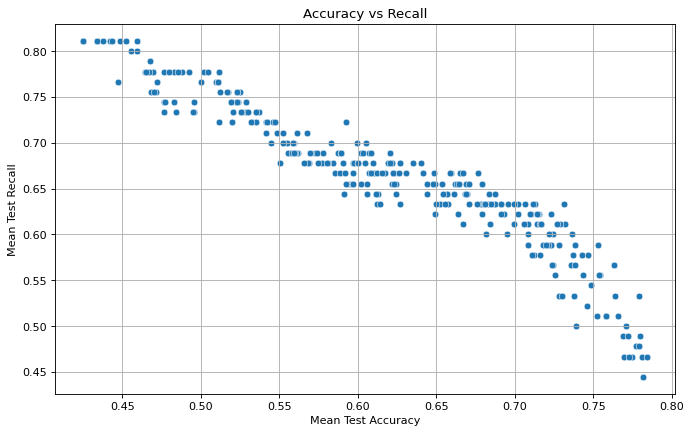

In [ ]:
# Plotting accuracy vs recall
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sorted_results_df, x='mean_test_accuracy', y='mean_test_recall')

plt.title('Accuracy vs Recall')
plt.xlabel('Mean Test Accuracy')
plt.ylabel('Mean Test Recall')
plt.grid(True)
plt.show()

The scatter plot visualizing Accuracy versus Recall serves as an important illustration of the trade-off between these two metrics, but also of the capability of the model to offer a pareto front of optimal solutions covering a wide range of Accuracy and Recall tradeoffs. The graph shows a spread of points where each represents a set of parameters used in the model, plotting their mean test Accuracy on the x-axis against the mean test Recall on the y-axis. The plot helps to identify how changes in the model parameters impact its ability to correctly identify defaults (Recall) as well as its overall predictive accuracy. Typically, as Recall increases, Accuracy may decrease, which is a common trade-off in classification tasks, especially on imbalanced datasets. This visual aid is crucial for model tuning, allowing us to seek in future work a balance that aligns with the project's objectives – maximizing the correct identification of defaults while maintaining a reasonable level of Accuracy. 

Subsequently, the optimal model was isolated, in an effort to better understand its predictive power and the features which played a more important role in the decision process.

In [ ]:
# Reconfiguring the pipeline with the specified parameters
rf_params = {
    'max_depth': 1, 
    'max_features': 0.809501, 
    'max_samples': 0.645173, 
    'n_estimators': 407
}

rf1_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ("model", RandomForestClassifier(**rf_params, random_state=42))
])

# Fitting the model
rf1_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sampler', RandomOverSampler(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=1, max_features=0.809501,
                                        max_samples=0.645173, n_estimators=407,
                                        random_state=42))])

Offering some further insight on the optimal parameters:

Max depth: A maximum depth equal with 1, denotes that the trees of the forest did on maximum two splits to be able to classify defaults with average Recall level of 0.81, one at the root node and one on the first level of depth. At each level of depth, each tree chose one feature among the max features and a threshold for that feature offering the best split based on the chosen impurity criterion. With maximum depth of 1, the optimal trees in the Random Forest are quite shallow, suggesting that either the dataset can be effectively modeled with very simple decision rules or that a deeper model might risk overfitting with the given data, given the extensive oversampling of the minority class.

Max features: Each split in a tree is in considering at maximum 80.95% of the features, i.e. approximately 53 features.

Max samples:  Each tree in the Random Forest is trained on max the 64.52% of the data samples, selected randomly. Since the training dataset contains 6,102 samples, each tree is trained on a random subset of about 3,937 samples. This sampling strategy contributes to model diversity and helps in reducing overfitting by ensuring that each tree learns from a different subset of the data.

Number of estimators: This means that the Random Forest method needed to produce 407 trees in the forest to be able to decide on classifying defaults with this level of Recall. This number suggests a point of diminishing returns was found where additional trees do not offer enough benefit in decision making to justify the additional computational cost.

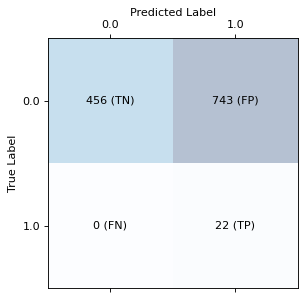

Recall = 1.0 Accuracy = 0.3914823914823915


In [ ]:
predictions_rs = rf1_pipe.predict(X_test)

# get the confusion matrix as a numpy array
confmat_rs = confusion_matrix(y_true = y_test, y_pred=predictions_rs)

# use the pretty function to make it nicer, you can give some name for LE.classes_ inside of the function
pretty_confusion_matrix(confmat_rs, LE.classes_, "",  labeling = True)

TP = confmat_rs[1, 1]
FP = confmat_rs[0, 1]
FN = confmat_rs[1, 0]
TN = confmat_rs[0, 0]

Recall = TP / (TP + FN)
Accu = (TP+TN)/ (TP+TN+FP+FN)

print('Recall =', Recall, 'Accuracy =', Accu)

The confusion matrix generated from testing the model provides a clear depiction of its classification performance. With a perfect Recall of 1.0, the model successfully identified all 22 true defaults (TP) in the test set. However, this high sensitivity to defaults came with the drawback of a considerable number of false positives (FP), where 743 out of the total 1221 test samples were incorrectly flagged as defaults. This led to an overall Accuracy of 39%, computed by considering both true positives and true negatives (TN), which were 456 cases correctly predicted as non-defaults.

The perfect Recall demonstrates the model's capability to detect all high-risk loans, which can be crucial in certain financial risk management scenarios where missing a defaulting loan could be costly. Yet, the substantial number of false positives signifies that while the model is excellent at identifying potential risk, it does so at the expense of misclassifying many non-defaulting loans as defaults, which can lead to inefficient allocation of resources for risk mitigation. Therefore, these results may necessitate a reevaluation of the model's threshold for classifying defaults or a more balanced approach to tuning the model to reduce the number of false positives without significantly compromising Recall.

AUC value: 0.7761012965349914


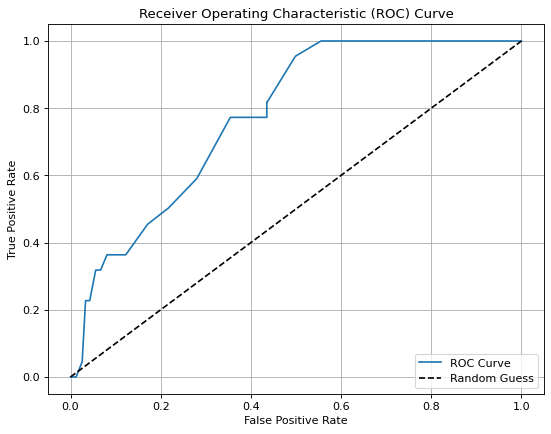

In [ ]:
# Compute ROC curve and ROC area for each class
predictions_v = rf1_pipe.predict_proba(X_test)

roc_calc_v = roc_curve(y_true = y_test, y_score = predictions_v[:,1])
roc_v = pd.DataFrame(
    data = np.c_[roc_calc_v],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

#Print the related AUC value 
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_v[:,1]))

plot_roc_curve(roc_v)

The Receiver Operating Characteristic (ROC) curve and the corresponding Area Under the Curve (AUC) score were examined to evaluate the performance of the optimal model in differentiating between default and non-default cases. The ROC curve is a graphical representation that illustrates a model's diagnostic ability, and an ideal curve hugs the top left corner of the plot, maximizing the True Positive Rate while minimizing the False Positive Rate. A model is generally considered to have good predictive ability when its ROC curve is significantly above the diagonal line, which represents random chance.

For this Random Forest model, the AUC score is 0.7761, which shows a marked improvement compared to the AUC score of 0.7473 from the logistic regression model. The improved AUC score indicate that the Random Forest model has superior discriminative power compared to the logistic regression model. These results imply that the Random Forest model is more effective in correctly classifying cases of default, making it a more robust tool for predicting mortgage defaults, especially in a conservative sense.

Finally, it was decided to use the attributes of the developed model, to understand the weight of each feature in the classification decision process. For this purpose, the attribute .feature_importances_ was used, which is calculated based on how much the tree nodes that use the corresponding feature reduce impurity on average across all trees in the forest. In more detail:

- Tree-Based Feature Importance: For each tree in the forest, the impurity decrease from each feature is accumulated every time the feature is used to split a node. The decrease is a measure of how well the feature splits the data into classes.

- Normalization: The total decrease in impurity is then averaged across all trees in the forest for each feature. This averaged decrease is the feature's importance score.

- Scaling: The scores are then normalized so that the sum of all feature importance scores equals 1. This means each score represents the relative importance of the feature in predicting the target variable, with higher scores indicating more important features.

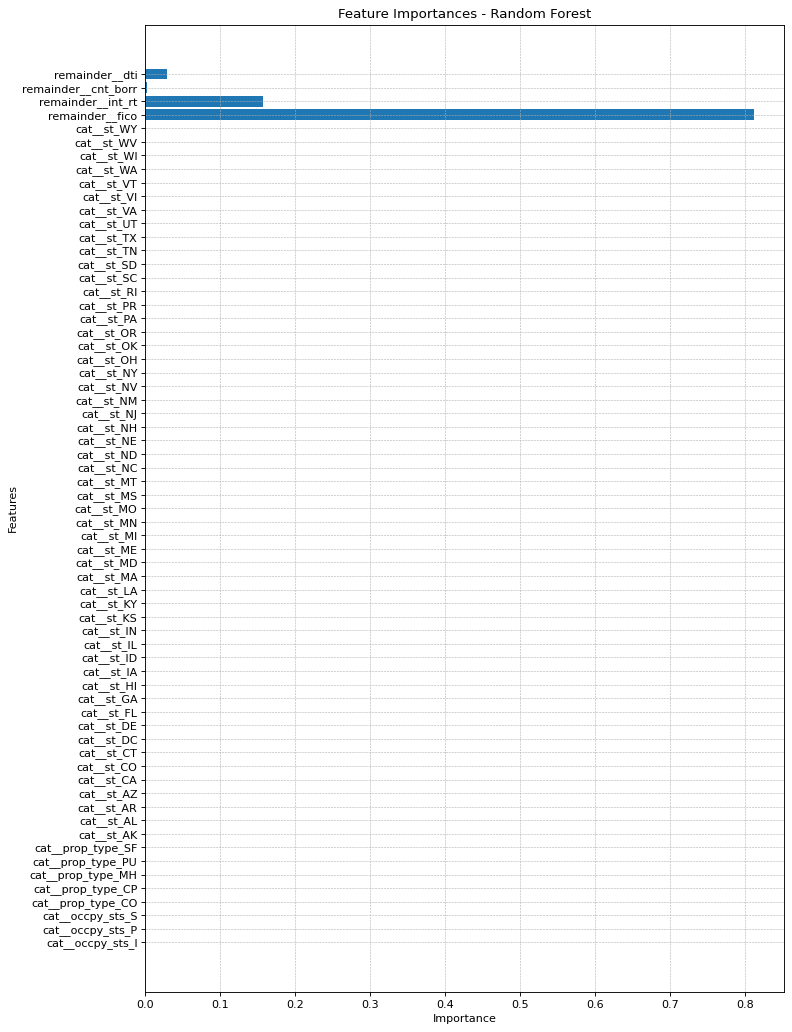

In [ ]:
# Accessing feature importances from the 'model' step of the pipeline
rf_importances = rf1_pipe.named_steps['model'].feature_importances_

# Assuming you have a list of feature names matching the order in X_train
feature_names = data_x.columns  # Adjusted from 'data_x.columns' to 'X_train.columns'

# Plotting feature importances
plt.figure(figsize=(10, len(feature_names) * 0.2))  # Adjust the multiplier as needed for spacing
plt.barh(feature_names, rf_importances)
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # This can help optimize the spacing
plt.show()

It is very interesting to observe that the optimal random forest model based its impurity reduction mostly on 4 features: 

- fico: the borrower's credit score, with an importance ratio of ~0.81. Dominating the chart, the borrower's FICO score emerges as the most influential factor with an overwhelming importance, signifying that the creditworthiness of a borrower, as encapsulated by their credit score, is by far the most critical predictor for default in this model.

- int_rt: the mortgage's interest rate, with an importance ratio of ~0.16. The second most significant feature is the mortgage's interest rate, though its importance pales in comparison to the FICO score. This suggests that while the interest rate is a key factor, its impact on the likelihood of default is considerably less than that of the FICO score.

- dti: the borrower's debt-to-income ratio, with an importance ratio of ~0.028. The DTI ratio also plays a role in predicting default, but its importance is relatively minor, indicating that while a borrower's debt relative to their income is a factor considered by the model, it is far less decisive than the credit score

- cnt_borr: the number of borrowers, with an importance ratio of ~0.002. With the least importance among the four, the number of borrowers involved in the mortgage has a very minor effect on the model's decision-making process, implying that the default risk is less sensitive to whether a loan is singly or jointly held.

The concentration of predictive power in these four features, especially the FICO score, implies that they are likely driving the majority of the model's decision-making process. This aligns with financial theory which places significant emphasis on a borrower's credit score as an indicator of default risk. The much lower importance of other features might reflect that, in the presence of a strong indicator like the FICO score, additional variables contribute incrementally but are not decisive on their own.

# Discussion & Conclusions



As we conclude our investigation into predictive models for loan default risk, we reflect on the findings in light of the model performances. The Random Forest model, after rigorous tuning and validation, has exhibited a remarkable ability to predict loan defaults, achieving a perfect Recall score (1.0) but with an Accuracy of 0.391. This indicates that while the model can identify all defaults, it also misclassifies a substantial number of non-default cases as defaults. This is visualized in the confusion matrix where we see 743 false positives against 22 true positives out of 1221 test samples.

The trade-off between Recall and Precision is particularly stark in our Random Forest model, underscored by an AUC of 0.7761, surpassing the logistic regression model's AUC of 0.7382. While the AUC score is satisfactory, indicating a good measure of separability, the high number of false positives signals the model's tendency to over-predict defaults, which could be problematic in practical scenarios.

Our optimized Random Forest model heavily relied on four main features: FICO score, interest rate, debt-to-income ratio, and the number of borrowers—mirroring the importance of creditworthiness, loan terms, and borrower's financial leverage as key indicators of default risk.

The paper titled "A Bayesian approach to modeling mortgage default and prepayment" by Bhattacharya, Wilson, and Soyer presents a Bayesian competing risk proportional hazards model to understand mortgage defaults and prepayments [1]. The study involves Markov chain Monte Carlo (MCMC) methods to infer the model parameters and uses actual default and prepayment data to illustrate its implementation.

The key variables identified in their study as significant to the model are: 

Credit Score, Mortgage Insurance %, Original Debt-to-Income Ratio (DTI), Unpaid Principal Balance (UPB), Original Interest Rate, Number of Borrowers, First-Time Homebuyer Status, Foreclosure State, Property Type.

Comparatively, in the paper referenced, the model focused on different variables, such as the original unpaid balance. While those factors are undeniably influential, our model's emphasis on borrower-specific financial health markers (e.g., FICO score) proved more predictive for our dataset, possibly indicating the dynamic and individualized nature of default risk.

The Random Forest model demonstrated the capability of locating various optimal solutions, depending on the researchers thresholds of Recall and Accuracy. Our findings suggest potential areas for future improvement, such as adjusting the model's oversampling, its threshold for predicting defaults or further exploring feature selection to refine the balance between Recall and Precision.

In practical application, the implications of our model's high Recall could be significant for institutions like Freddie Mac. It suggests a conservative strategy where nearly all defaults are flagged, but at the cost of increased false positives. Such a model could be useful in scenarios where missing a default could lead to severe financial repercussions, although it would require additional resources to handle the volume of flagged cases.

In reflecting upon the conservativeness of our model, it becomes apparent that the high Recall rate may denote a cautious approach. The model’s inclination to err on the side of caution, flagging potential defaults liberally, suggests a strategy that prioritizes risk aversion. Given the constraints of the dataset at our disposal, the time frame, and the objectives, this conservative model serves as a strong starting point. However, it is also an acknowledgment that there is room for refinement depending on the Recall / Accuracy thresholds required by the contractors. Given this decision as input, further investigation is warranted to fine-tune the model’s Accuracy.

Ultimately, our study has contributed to the ongoing analysis of loan default risks, aligning with the broader financial industry's efforts to predict and mitigate these risks. Our model's capacity to identify default cases, despite its limitations, offers valuable insights into the factors that most strongly influence loan default, paving the way for more focused risk management strategies.

# References

[1] Bhattacharya, A., Wilson, S.P. and Soyer, R. (2019). A Bayesian approach to modeling mortgage default and prepayment. European Journal of Operational Research, 274(3), pp.1112–1124. doi:https://doi.org/10.1016/j.ejor.2018.10.047.

[2] Single Family Loan-Level Dataset. [online] Available at: https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset.

[3] Technology Integration Outlook Single-Family Loan-Level Dataset General User Guide. (2024). Available at: https://www.freddiemac.com/fmac-resources/research/pdf/user_guide.pdf.

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] WARNING | pattern 'project2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Ex